In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True, tuning_ratio = 0.1):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == tuning_ratio)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
test_path = './results/eval_ilt.txt'
df_grouped = prep_and_store_results(test_path)

['ILT', '0.5', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.0000005', '4']
Lengths {13}
Number of evaluations: 2352
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,35.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
1,ILT,image_to_text_R@1,45.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
2,ILT,image_to_text_R@5,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
3,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
4,ILT,text_to_image_R@1,65.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2347,ILT,image_to_text_R@5,90.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2348,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2349,ILT,text_to_image_R@1,35.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2350,ILT,text_to_image_R@5,80.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,35.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
1,ILT,image_to_text_R@1,45.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
2,ILT,image_to_text_R@5,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
3,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
4,ILT,text_to_image_R@1,65.0,0.5,base,False,NaN,NaN,None,5,5.000000e-07,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2347,ILT,image_to_text_R@5,90.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2348,ILT,image_to_text_R@10,95.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2349,ILT,text_to_image_R@1,35.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16
2350,ILT,text_to_image_R@5,80.0,0.5,base,False,NaN,NaN,None,30,5.000000e-05,16


value  \
                                                                                                   mean   
method PL   AL.epochs AL.iter metric            bs lr           dataset ratio epochs ProbVLM              
base   None NaN       NaN     image_to_text_R@1 4  5.000000e-07 ILT     0.5   5      False    41.666667   
                                                                              10     False    45.555556   
                                                                              15     False    44.444444   
                                                                              20     False    50.000000   
                                                                              25     False    45.000000   
...                                                                                                 ...   
                              zeroshot-val-top1 16 5.000000e-05 ILT-CLS 0.5   10     False    39.000000   
                                                                              15     False    42.000000   
                                                                              20     False    46.000000   
                                                                              25     False    49.000000   
                                                                              30     False    47.000000   

                                                                                                         \
                                                                                                    std   
method PL   AL.epochs AL.iter metric            bs lr           dataset ratio epochs ProbVLM              
base   None NaN       NaN     image_to_text_R@1 4  5.000000e-07 ILT     0.5   5      False     2.500000   
                                                                              10     False     6.346478   
                                                                              15     False     3.908680   
                                                                              20     False     5.590170   
                                                                              25     False     8.660254   
...                                                                                                 ...   
                              zeroshot-val-top1 16 5.000000e-05 ILT-CLS 0.5   10     False     8.215838   
                                                                              15     False     2.738613   
                                                                              20     False    11.401754   
                                                                              25     False     4.183300   
                                                                              30     False     5.700877   

                                                                                                    
                                                                                             count  
method PL   AL.epochs AL.iter metric            bs lr           dataset ratio epochs ProbVLM        
base   None NaN       NaN     image_to_text_R@1 4  5.000000e-07 ILT     0.5   5      False       9  
                                                                              10     False       9  
                                                                              15     False       9  
                                                                              20     False       9  
                                                                              25     False       9  
...                                                                                            ...  
                              zeroshot-val-top1 16 5.000000e-05 ILT-CLS 0.5   10     False       5  
                                                                              15     False

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method    PL AL.epochs AL.iter             metric bs       lr  dataset  \
                                                                             
12    base  None       5.0     NaN  image_to_text_R@1  4  0.00005      ILT   
13    base  None      10.0     NaN  image_to_text_R@1  4  0.00005      ILT   
30    base  None       5.0     NaN  image_to_text_R@1  8  0.00005      ILT   
14    base  None      15.0     NaN  image_to_text_R@1  4  0.00005      ILT   
31    base  None      10.0     NaN  image_to_text_R@1  8  0.00005      ILT   
..     ...   ...       ...     ...                ... ..      ...      ...   
341   base  None      30.0     NaN  zeroshot-val-top1  4  0.00005  ILT-CLS   
359   base  None      30.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
358   base  None      25.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
357   base  None      20.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
356   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   

    ratio epochs ProbVLM value                   
                          mean        std count  
12    0.5      5   False  33.0   8.366600     5  
13    0.5     10   False  35.0   9.354143     5  
30    0.5      5   False  35.0   9.354143     5  
14    0.5     15   False  38.0  10.368221     5  
31    0.5     10   False  39.0   6.519202     5  
..    ...    ...     ...   ...        ...   ...  
341   0.5     30   False  52.0   4.472136     5  
359   0.5     30   False  53.0   6.708204     5  
358   0.5     25   False  55.0   6.123724     5  
357   0.5     20   False  58.0   9.082951     5  
356   0.5     15   False  59.0  12.942179     5  

[378 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, tuning_ratio = 0.5)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

method    PL AL.epochs AL.iter              metric  bs            lr  \
                                                                           
44    base  None      15.0     NaN   image_to_text_R@1  16  5.000000e-06   
36    base  None       5.0     NaN   image_to_text_R@1  16  5.000000e-07   
42    base  None       5.0     NaN   image_to_text_R@1  16  5.000000e-06   
99    base  None      20.0     NaN  image_to_text_R@10  16  5.000000e-06   
100   base  None      25.0     NaN  image_to_text_R@10  16  5.000000e-06   
102   base  None       5.0     NaN  image_to_text_R@10  16  5.000000e-05   
144   base  None       5.0     NaN   image_to_text_R@5  16  5.000000e-07   
145   base  None      10.0     NaN   image_to_text_R@5  16  5.000000e-07   
146   base  None      15.0     NaN   image_to_text_R@5  16  5.000000e-07   
180   base  None       5.0     NaN   text_to_image_R@1   8  5.000000e-07   
182   base  None      15.0     NaN   text_to_image_R@1   8  5.000000e-07   
200   base  None      15.0     NaN   text_to_image_R@1  16  5.000000e-07   
256   base  None      25.0     NaN  text_to_image_R@10  16  5.000000e-07   
258   base  None       5.0     NaN  text_to_image_R@10  16  5.000000e-06   
259   base  None      10.0     NaN  text_to_image_R@10  16  5.000000e-06   
318   base  None       5.0     NaN   text_to_image_R@5  16  5.000000e-05   
306   base  None       5.0     NaN   text_to_image_R@5  16  5.000000e-07   
312   base  None       5.0     NaN   text_to_image_R@5  16  5.000000e-06   
358   base  None      25.0     NaN   zeroshot-val-top1   8  5.000000e-05   
357   base  None      20.0     NaN   zeroshot-val-top1   8  5.000000e-05   
356   base  None      15.0     NaN   zeroshot-val-top1   8  5.000000e-05   

     dataset ratio epochs ProbVLM       value                   
                                         mean        std count  
44       ILT   0.5     15   False   55.000000  11.726039     5  
36       ILT   0.5      5   False   63.125000   2.587746     8  
42       ILT   0.5      5   False   68.000000   2.738613     5  
99       ILT   0.5     20   False  100.000000   0.000000     5  
100      ILT   0.5     25   False  100.000000   0.000000     5  
102      ILT   0.5      5   False  100.000000   0.000000     5  
144      ILT   0.5      5   False  100.000000   0.000000     8  
145      ILT   0.5     10   False  100.000000   0.000000     8  
146      ILT   0.5     15   False  100.000000   0.000000     8  
180      ILT   0.5      5   False   54.444444   6.346478     9  
182      ILT   0.5     15   False   55.555556   3.908680     9  
200      ILT   0.5     15   False   55.625000   4.955156     8  
256      ILT   0.5     25   False  100.000000   0.000000     8  
258      ILT   0.5      5   False  100.000000   0.000000     5  
259      ILT   0.5     10   False  100.000000   0.000000     5  
318      ILT   0.5      5   False   97.000000   2.738613     5  
306      ILT   0.5      5   False  100.000000   0.000000     8  
312      ILT   0.5      5   False  100.000000   0.000000     5  
358  ILT-CLS   0.5     25   False   55.000000   6.123724     5  
357  ILT-CLS   0.5     20   False   58.000000   9.082951     5  
356  ILT-CLS   0.5     15   False   59.000000  12.942179     5

# Test split evaluation results

In [7]:
test_path = './results/test_eval_ilt.txt'
df_grouped = prep_and_store_results(test_path)

['ILT', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '8']
Lengths {13}
Number of evaluations: 700
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,66.67,0.05,base,False,NaN,NaN,None,5,0.00005,8
1,ILT,image_to_text_R@1,57.14,0.05,base,False,NaN,NaN,None,5,0.00005,8
2,ILT,image_to_text_R@5,95.24,0.05,base,False,NaN,NaN,None,5,0.00005,8
3,ILT,image_to_text_R@10,100.00,0.05,base,False,NaN,NaN,None,5,0.00005,8
4,ILT,text_to_image_R@1,57.14,0.05,base,False,NaN,NaN,None,5,0.00005,8
...,...,...,...,...,...,...,...,...,...,...,...,...
695,ILT,image_to_text_R@5,95.24,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
696,ILT,image_to_text_R@10,100.00,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
697,ILT,text_to_image_R@1,57.14,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
698,ILT,text_to_image_R@5,95.24,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,ILT-CLS,zeroshot-val-top1,66.67,0.05,base,False,NaN,NaN,None,5,0.00005,8
1,ILT,image_to_text_R@1,57.14,0.05,base,False,NaN,NaN,None,5,0.00005,8
2,ILT,image_to_text_R@5,95.24,0.05,base,False,NaN,NaN,None,5,0.00005,8
3,ILT,image_to_text_R@10,100.00,0.05,base,False,NaN,NaN,None,5,0.00005,8
4,ILT,text_to_image_R@1,57.14,0.05,base,False,NaN,NaN,None,5,0.00005,8
...,...,...,...,...,...,...,...,...,...,...,...,...
695,ILT,image_to_text_R@5,95.24,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
696,ILT,image_to_text_R@10,100.00,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
697,ILT,text_to_image_R@1,57.14,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8
698,ILT,text_to_image_R@5,95.24,0.05,ours,False,NaN,NaN,soft.text,15,0.00005,8


value  \
                                                                                                 mean   
method PL        AL.epochs AL.iter metric             bs lr      dataset ratio epochs ProbVLM           
base   None      5.0       5.0     image_to_text_R@1  8  0.00005 ILT     0.05  15     False     57.14   
                                   image_to_text_R@10 8  0.00005 ILT     0.05  15     False    100.00   
                                   image_to_text_R@5  8  0.00005 ILT     0.05  15     False     95.24   
                                   text_to_image_R@1  8  0.00005 ILT     0.05  15     False     57.14   
                                   text_to_image_R@10 8  0.00005 ILT     0.05  15     False    100.00   
...                                                                                               ...   
ours   soft.text NaN       NaN     zeroshot-val-top1  8  0.00005 ILT-CLS 0.05  15     False     66.67   
                                                                         0.10  15     False     23.81   
                                                                         0.20  15     False     28.57   
                                                                         0.40  15     False     57.14   
                                                                         0.80  15     False     52.38   

                                                                                                    \
                                                                                               std   
method PL        AL.epochs AL.iter metric             bs lr      dataset ratio epochs ProbVLM        
base   None      5.0       5.0     image_to_text_R@1  8  0.00005 ILT     0.05  15     False    NaN   
                                   image_to_text_R@10 8  0.00005 ILT     0.05  15     False    NaN   
                                   image_to_text_R@5  8  0.00005 ILT     0.05  15     False    NaN   
                                   text_to_image_R@1  8  0.00005 ILT     0.05  15     False    NaN   
                                   text_to_image_R@10 8  0.00005 ILT     0.05  15     False    NaN   
...                                                                                            ...   
ours   soft.text NaN       NaN     zeroshot-val-top1  8  0.00005 ILT-CLS 0.05  15     False    0.0   
                                                                         0.10  15     False    NaN   
                                                                         0.20  15     False    NaN   
                                                                         0.40  15     False    NaN   
                                                                         0.80  15     False    NaN   

                                                                                                     
                                                                                              count  
method PL        AL.epochs AL.iter metric             bs lr      dataset ratio epochs ProbVLM        
base   None      5.0       5.0     image_to_text_R@1  8  0.00005 ILT     0.05  15     False       1  
                                   image_to_text_R@10 8  0.00005 ILT     0.05  15     False       1  
                                   image_to_text_R@5  8  0.00005 ILT     0.05  15     False       1  
                                   text_to_image_R@1  8  0.00005 ILT     0.05  15     False       1  
                                   text_to_image_R@10 8  0.00005 ILT     0.05  15     False       1  
...                                                                                             ...  
ours   soft.text NaN       NaN     zeroshot-val-top1  8  0.00005 ILT-CLS 0.05  15     False       4  
                                                                         0.10  15     False       1  
                                                                         0

In [8]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
178   ours   ot.image      15.0     NaN  image_to_text_R@1  8  0.00005   
179   ours   ot.image      15.0     NaN  image_to_text_R@1  8  0.00005   
180   ours   ot.image      15.0     NaN  image_to_text_R@1  8  0.00005   
181   ours   ot.image      15.0     NaN  image_to_text_R@1  8  0.00005   
225   ours  soft.text      15.0     NaN  image_to_text_R@1  8  0.00005   
..     ...        ...       ...     ...                ... ..      ...   
170   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
217   ours   ot.image       5.0     NaN  zeroshot-val-top1  8  0.00005   
218   ours   ot.image      10.0     NaN  zeroshot-val-top1  8  0.00005   
219   ours   ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   
254   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   

     dataset ratio epochs ProbVLM  value             
                                    mean  std count  
178      ILT  0.10     15   False   4.76  NaN     1  
179      ILT  0.20     15   False   4.76  NaN     1  
180      ILT  0.40     15   False   4.76  NaN     1  
181      ILT  0.80     15   False   4.76  NaN     1  
225      ILT  0.10     15   False  19.05  NaN     1  
..       ...   ...    ...     ...    ...  ...   ...  
170  ILT-CLS  0.05     15   False  66.67  NaN     1  
217  ILT-CLS  0.05      5   False  66.67  NaN     1  
218  ILT-CLS  0.05     10   False  66.67  NaN     1  
219  ILT-CLS  0.05     15   False  66.67  NaN     1  
254  ILT-CLS  0.05     15   False  66.67  0.0     4  

[259 rows x 14 columns]

In [9]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [10]:
# display(df_no_finetune)

In [11]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

Empty DataFrame
Columns: [(method, ), (PL, ), (AL.epochs, ), (AL.iter, ), (metric, ), (bs, ), (lr, ), (dataset, ), (ratio, ), (epochs, ), (ProbVLM, ), (value, mean), (value, std), (value, count)]
Index: []

In [12]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [13]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [15], 'basic-al': [15], 'probvlm': [15], 's-clip': [15], 'soft-pl': [15], 
              'hard-pl': [15],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                pad_start = 1 
                # compute how much to pad at end - this is equal to 1 if all results are known
                pad_end = len(label_ratios) - len(performance) - pad_start 
#                 print('pad end:', pad_end)
                performance = np.pad(performance, ((pad_start, pad_end)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((pad_start, pad_end)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                           
67   base  None      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
70   base  None      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
73   base  None      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
76   base  None      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
79   base  None      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   

   ratio epochs ProbVLM  value             
                          mean  std count  
67  0.05     15   False  95.24  0.0     5  
70  0.10     15   False  95.24  0.0     5  
73  0.20     15   False  80.95  0.0     5  
76  0.40     15   False  90.48  0.0     5  
79  0.80     15   False  85.71  0.0     5

s-clip image_to_text_R@5 ILT


method        PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                                
191   ours  ot.image      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
192   ours  ot.image      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
193   ours  ot.image      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
194   ours  ot.image      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   
195   ours  ot.image      15.0     NaN  image_to_text_R@5  8  0.00005     ILT   

    ratio epochs ProbVLM  value            
                           mean std count  
191  0.05     15   False  95.24 NaN     1  
192  0.10     15   False  23.81 NaN     1  
193  0.20     15   False  23.81 NaN     1  
194  0.40     15   False  23.81 NaN     1  
195  0.80     15   False  23.81 NaN     1

soft-pl image_to_text_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
234   ours  soft.text      15.0     NaN  image_to_text_R@5  8  0.00005   
235   ours  soft.text      15.0     NaN  image_to_text_R@5  8  0.00005   
236   ours  soft.text      15.0     NaN  image_to_text_R@5  8  0.00005   
237   ours  soft.text      15.0     NaN  image_to_text_R@5  8  0.00005   
238   ours  soft.text      15.0     NaN  image_to_text_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value             
                                   mean  std count  
234     ILT  0.05     15   False  95.24  0.0     4  
235     ILT  0.10     15   False  71.43  NaN     1  
236     ILT  0.20     15   False  61.90  NaN     1  
237     ILT  0.40     15   False  66.67  NaN     1  
238     ILT  0.80     15   False  80.95  NaN     1

hard-pl image_to_text_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
150   ours  hard.text      15.0     NaN  image_to_text_R@5  8  0.00005   
151   ours  hard.text      15.0     NaN  image_to_text_R@5  8  0.00005   
152   ours  hard.text      15.0     NaN  image_to_text_R@5  8  0.00005   
153   ours  hard.text      15.0     NaN  image_to_text_R@5  8  0.00005   
154   ours  hard.text      15.0     NaN  image_to_text_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value            
                                   mean std count  
150     ILT  0.05     15   False  95.24 NaN     1  
151     ILT  0.10     15   False  71.43 NaN     1  
152     ILT  0.20     15   False  61.90 NaN     1  
153     ILT  0.40     15   False  80.95 NaN     1  
154     ILT  0.80     15   False  90.48 NaN     1

basic-al image_to_text_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                           
2    base  None       5.0     5.0  image_to_text_R@5  8  0.00005     ILT   
9    base  None       5.0    10.0  image_to_text_R@5  8  0.00005     ILT   
16   base  None       5.0    20.0  image_to_text_R@5  8  0.00005     ILT   
23   base  None       5.0    40.0  image_to_text_R@5  8  0.00005     ILT   
30   base  None       5.0    80.0  image_to_text_R@5  8  0.00005     ILT   

   ratio epochs ProbVLM  value            
                          mean std count  
2   0.05     15   False  95.24 NaN     1  
9   0.10     15   False  95.24 NaN     1  
16  0.20     15   False  71.43 NaN     1  
23  0.40     15   False  57.14 NaN     1  
30  0.80     15   False  80.95 NaN     1

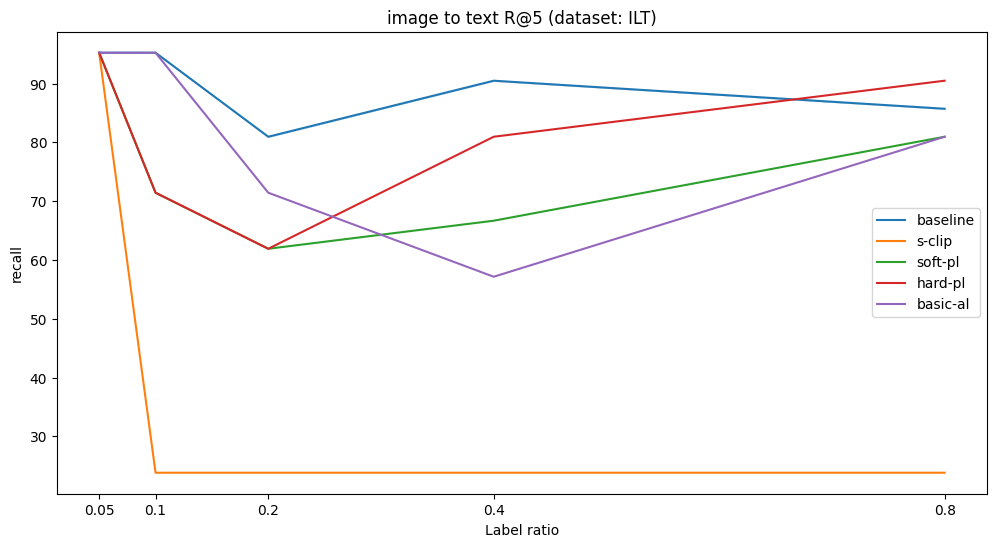

baseline text_to_image_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                            
112   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
115   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
118   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
121   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
124   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   

    ratio epochs ProbVLM  value             
                           mean  std count  
112  0.05     15   False  95.24  0.0     5  
115  0.10     15   False  95.24  0.0     5  
118  0.20     15   False  80.95  0.0     5  
121  0.40     15   False  80.95  0.0     5  
124  0.80     15   False  95.24  0.0     5

s-clip text_to_image_R@5 ILT


method        PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                                
212   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
213   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
214   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
215   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
216   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   

    ratio epochs ProbVLM  value            
                           mean std count  
212  0.05     15   False  95.24 NaN     1  
213  0.10     15   False  23.81 NaN     1  
214  0.20     15   False  23.81 NaN     1  
215  0.40     15   False  23.81 NaN     1  
216  0.80     15   False  23.81 NaN     1

soft-pl text_to_image_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
249   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
250   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
251   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
252   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
253   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value             
                                   mean  std count  
249     ILT  0.05     15   False  95.24  0.0     4  
250     ILT  0.10     15   False  76.19  NaN     1  
251     ILT  0.20     15   False  66.67  NaN     1  
252     ILT  0.40     15   False  76.19  NaN     1  
253     ILT  0.80     15   False  90.48  NaN     1

hard-pl text_to_image_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
165   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
166   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
167   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
168   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
169   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value            
                                   mean std count  
165     ILT  0.05     15   False  95.24 NaN     1  
166     ILT  0.10     15   False  61.90 NaN     1  
167     ILT  0.20     15   False  61.90 NaN     1  
168     ILT  0.40     15   False  90.48 NaN     1  
169     ILT  0.80     15   False  80.95 NaN     1

basic-al text_to_image_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                           
5    base  None       5.0     5.0  text_to_image_R@5  8  0.00005     ILT   
12   base  None       5.0    10.0  text_to_image_R@5  8  0.00005     ILT   
19   base  None       5.0    20.0  text_to_image_R@5  8  0.00005     ILT   
26   base  None       5.0    40.0  text_to_image_R@5  8  0.00005     ILT   
33   base  None       5.0    80.0  text_to_image_R@5  8  0.00005     ILT   

   ratio epochs ProbVLM  value            
                          mean std count  
5   0.05     15   False  95.24 NaN     1  
12  0.10     15   False  95.24 NaN     1  
19  0.20     15   False  66.67 NaN     1  
26  0.40     15   False  66.67 NaN     1  
33  0.80     15   False  80.95 NaN     1

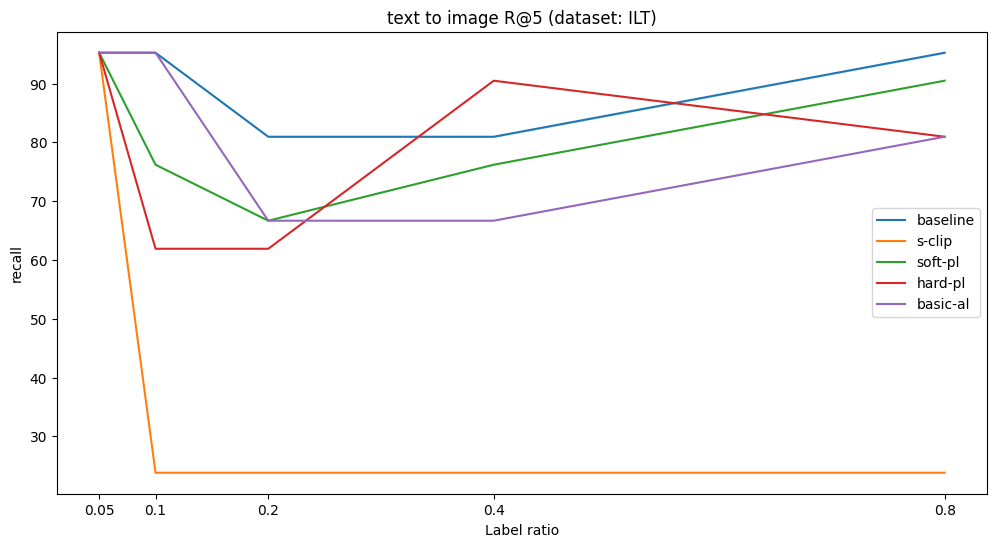

In [14]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['ILT']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

ILT-CLS zeroshot-val-top1
baseline zeroshot-val-top1 ILT-CLS


method    PL AL.epochs AL.iter             metric bs       lr  dataset  \
                                                                             
127   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
130   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
133   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
136   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   
139   base  None      15.0     NaN  zeroshot-val-top1  8  0.00005  ILT-CLS   

    ratio epochs ProbVLM  value                      
                           mean           std count  
127  0.05     15   False  66.67  0.000000e+00     5  
130  0.10     15   False  66.67  0.000000e+00     5  
133  0.20     15   False  42.86  0.000000e+00     5  
136  0.40     15   False  52.38  7.944109e-15     5  
139  0.80     15   False  47.62  0.000000e+00     5

s-clip zeroshot-val-top1 ILT-CLS


method        PL AL.epochs AL.iter             metric bs       lr  \
                                                                        
219   ours  ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   
220   ours  ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   
221   ours  ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   
222   ours  ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   
223   ours  ot.image      15.0     NaN  zeroshot-val-top1  8  0.00005   

     dataset ratio epochs ProbVLM  value            
                                    mean std count  
219  ILT-CLS  0.05     15   False  66.67 NaN     1  
220  ILT-CLS  0.10     15   False  19.05 NaN     1  
221  ILT-CLS  0.20     15   False  19.05 NaN     1  
222  ILT-CLS  0.40     15   False  19.05 NaN     1  
223  ILT-CLS  0.80     15   False  19.05 NaN     1

soft-pl zeroshot-val-top1 ILT-CLS


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
254   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
255   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
256   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
257   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
258   ours  soft.text      15.0     NaN  zeroshot-val-top1  8  0.00005   

     dataset ratio epochs ProbVLM  value             
                                    mean  std count  
254  ILT-CLS  0.05     15   False  66.67  0.0     4  
255  ILT-CLS  0.10     15   False  23.81  NaN     1  
256  ILT-CLS  0.20     15   False  28.57  NaN     1  
257  ILT-CLS  0.40     15   False  57.14  NaN     1  
258  ILT-CLS  0.80     15   False  52.38  NaN     1

hard-pl zeroshot-val-top1 ILT-CLS


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
170   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
171   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
172   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
173   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   
174   ours  hard.text      15.0     NaN  zeroshot-val-top1  8  0.00005   

     dataset ratio epochs ProbVLM  value            
                                    mean std count  
170  ILT-CLS  0.05     15   False  66.67 NaN     1  
171  ILT-CLS  0.10     15   False  28.57 NaN     1  
172  ILT-CLS  0.20     15   False  38.10 NaN     1  
173  ILT-CLS  0.40     15   False  23.81 NaN     1  
174  ILT-CLS  0.80     15   False  28.57 NaN     1

basic-al zeroshot-val-top1 ILT-CLS


method    PL AL.epochs AL.iter             metric bs       lr  dataset  \
                                                                            
6    base  None       5.0     5.0  zeroshot-val-top1  8  0.00005  ILT-CLS   
13   base  None       5.0    10.0  zeroshot-val-top1  8  0.00005  ILT-CLS   
20   base  None       5.0    20.0  zeroshot-val-top1  8  0.00005  ILT-CLS   
27   base  None       5.0    40.0  zeroshot-val-top1  8  0.00005  ILT-CLS   
34   base  None       5.0    80.0  zeroshot-val-top1  8  0.00005  ILT-CLS   

   ratio epochs ProbVLM  value            
                          mean std count  
6   0.05     15   False  66.67 NaN     1  
13  0.10     15   False  66.67 NaN     1  
20  0.20     15   False  38.10 NaN     1  
27  0.40     15   False  33.33 NaN     1  
34  0.80     15   False  61.90 NaN     1

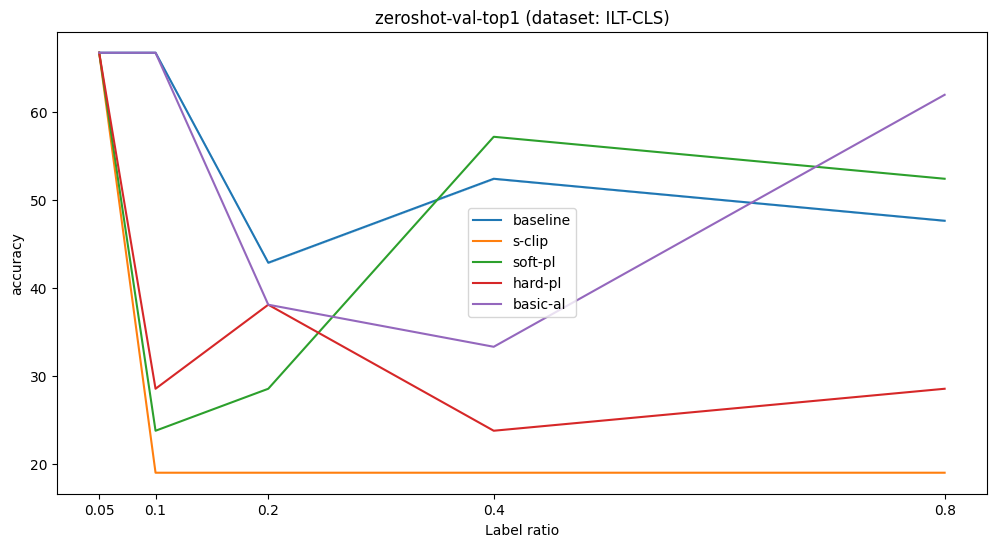

In [15]:
metric = 'zeroshot-val-top1'
datasets = ["ILT-CLS"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                            
112   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
115   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
118   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
121   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
124   base  None      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   

    ratio epochs ProbVLM  value             
                           mean  std count  
112  0.05     15   False  95.24  0.0     5  
115  0.10     15   False  95.24  0.0     5  
118  0.20     15   False  80.95  0.0     5  
121  0.40     15   False  80.95  0.0     5  
124  0.80     15   False  95.24  0.0     5

s-clip text_to_image_R@5 ILT


method        PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                                
212   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
213   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
214   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
215   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   
216   ours  ot.image      15.0     NaN  text_to_image_R@5  8  0.00005     ILT   

    ratio epochs ProbVLM  value            
                           mean std count  
212  0.05     15   False  95.24 NaN     1  
213  0.10     15   False  23.81 NaN     1  
214  0.20     15   False  23.81 NaN     1  
215  0.40     15   False  23.81 NaN     1  
216  0.80     15   False  23.81 NaN     1

soft-pl text_to_image_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
249   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
250   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
251   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
252   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   
253   ours  soft.text      15.0     NaN  text_to_image_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value             
                                   mean  std count  
249     ILT  0.05     15   False  95.24  0.0     4  
250     ILT  0.10     15   False  76.19  NaN     1  
251     ILT  0.20     15   False  66.67  NaN     1  
252     ILT  0.40     15   False  76.19  NaN     1  
253     ILT  0.80     15   False  90.48  NaN     1

hard-pl text_to_image_R@5 ILT


method         PL AL.epochs AL.iter             metric bs       lr  \
                                                                         
165   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
166   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
167   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
168   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   
169   ours  hard.text      15.0     NaN  text_to_image_R@5  8  0.00005   

    dataset ratio epochs ProbVLM  value            
                                   mean std count  
165     ILT  0.05     15   False  95.24 NaN     1  
166     ILT  0.10     15   False  61.90 NaN     1  
167     ILT  0.20     15   False  61.90 NaN     1  
168     ILT  0.40     15   False  90.48 NaN     1  
169     ILT  0.80     15   False  80.95 NaN     1

basic-al text_to_image_R@5 ILT


method    PL AL.epochs AL.iter             metric bs       lr dataset  \
                                                                           
5    base  None       5.0     5.0  text_to_image_R@5  8  0.00005     ILT   
12   base  None       5.0    10.0  text_to_image_R@5  8  0.00005     ILT   
19   base  None       5.0    20.0  text_to_image_R@5  8  0.00005     ILT   
26   base  None       5.0    40.0  text_to_image_R@5  8  0.00005     ILT   
33   base  None       5.0    80.0  text_to_image_R@5  8  0.00005     ILT   

   ratio epochs ProbVLM  value            
                          mean std count  
5   0.05     15   False  95.24 NaN     1  
12  0.10     15   False  95.24 NaN     1  
19  0.20     15   False  66.67 NaN     1  
26  0.40     15   False  66.67 NaN     1  
33  0.80     15   False  80.95 NaN     1

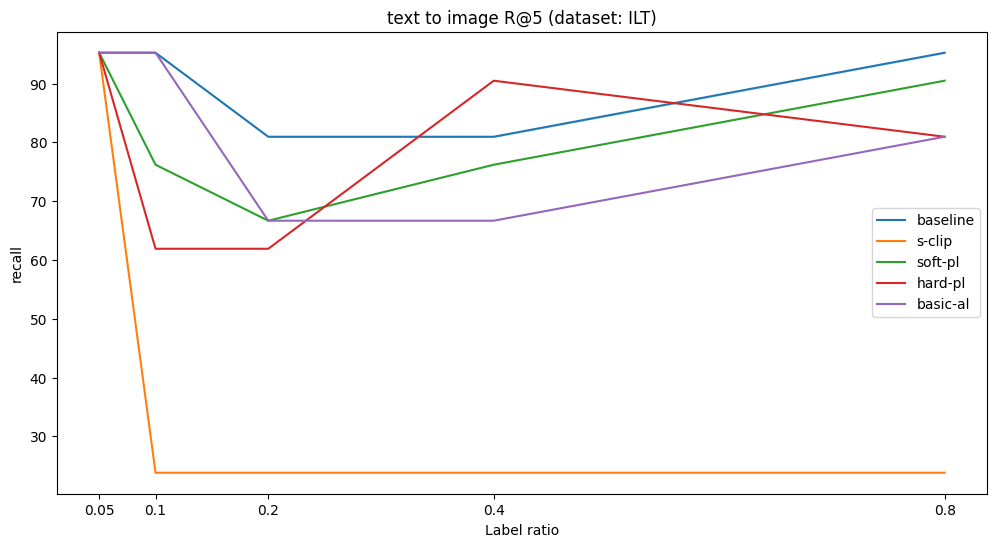

In [16]:
metric = 'text_to_image_R@5'
datasets = ['ILT']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)